# Horse to Zebra Unpaired Image Translation with CycleGAN in FastEstimator

This notebook demonstrates how to perform an unpaired image to image translation using CycleGAN in FastEstimator.
The details of the method is found in [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593).
We will specifically look at the problem of translating horse images to zebra images.

In [1]:
import os
import cv2
import time

import tensorflow as tf
import fastestimator as fe

import matplotlib
from matplotlib import pyplot as plt

## Step 1: Defining Input Pipeline

First, we will download the dataset of horses and zebras via our dataset API.
The images will be first downloaded from [here](https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/).
Then, two csv files containing relative paths to these images as *trainA.csv* and *trainB.csv*.
The root path of the downloaded images will be *parent_path*.

In [2]:
from fastestimator.dataset.horse2zebra import load_data
trainA_csv, trainB_csv, _, _, parent_path = load_data()

Once the images are downloaded, we will create *tfrecords* that will be used extensively by *Pipeline*.
*RecordWriter* will create tfrecords using the csv files as an input; *ImageReader* operator will take each row in the csv file to read images. The tfrecords will be saved under a folder named *FEdata*.

In [3]:
from fastestimator.record.preprocess import ImageReader

tfr_save_dir = os.path.join(parent_path, 'FEdata')
writer = fe.RecordWriter(
    train_data=(trainA_csv, trainB_csv),                                                                          
    save_dir=tfr_save_dir,                                                                                        
    ops=([ImageReader(inputs="imgA", outputs="imgA", parent_path=parent_path)],                                   
         [ImageReader(inputs="imgB", outputs="imgB", parent_path=parent_path)]))       

We need to define two custom operators to preprocess input images:
1. Rescaling the pixel values to be between -1 and 1
2. Random image augmentation applying a random jitter followed by a random horizontal flip as described in the [paper](https://arxiv.org/abs/1703.10593).
Each operator is defined by inheriting from base class ``fastestimator.util.op.TensorOp``.
The data transform function is defined within ``forward`` method.

In [4]:
from fastestimator.util.op import TensorOp

class Myrescale(TensorOp):
    def forward(self, data, state):
        data = tf.cast(data, tf.float32)
        data = (data - 127.5) / 127.5
        return data
    
class RandomAug(TensorOp):
    def forward(self, data, state):
        # resizing to 286 x 286 x 3
        data = tf.image.resize(data, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        # randomly cropping to 256 x 256 x 3
        data = tf.image.random_crop(data, size=[256, 256, 3]) 

        # random mirroring
        data = tf.image.random_flip_left_right(data)

        return data

Given these operators and *tfrecord* writer, we can now define `Pipeline` object.

In [5]:
pipeline = fe.Pipeline(
    data=writer,
    batch_size=1,
    ops=[
        Myrescale(inputs="imgA", outputs="imgA"),
        RandomAug(inputs="imgA", outputs="real_A"),
        Myrescale(inputs="imgB", outputs="imgB"),
        RandomAug(inputs="imgB", outputs="real_B")
    ])

We can visualize sample images from the ``pipeline`` using ``show_results`` method.
``show_results`` returns a list of batch data.
By default, it only returns only one batch of data.

For visualization purpose only, we normalize the pixel values to between 0 and 1.
Because ``ImageReader`` operator internally uses ``cv2.imread``, we need to perform color transformation for proper visualization.

In [6]:
def normalize_and_convert_color(img):
    img = img.numpy()
    img = (img + 1) * 0.5
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

FastEstimator: Reading non-empty directory: /tmp/.fe/HORSE2ZEBRA/FEdata
FastEstimator: Found 1334 examples for train in /tmp/.fe/HORSE2ZEBRA/FEdata/train_summary1.json
FastEstimator: Found 1067 examples for train in /tmp/.fe/HORSE2ZEBRA/FEdata/train_summary0.json


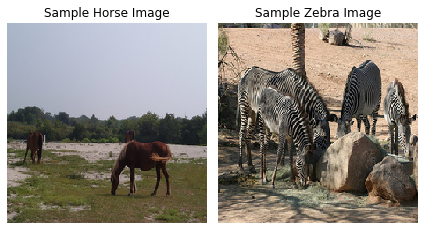

In [7]:
sample_batch = pipeline.show_results()
horse_img = sample_batch[0]["real_A"]
horse_img = normalize_and_convert_color(horse_img[0])

zebra_img = sample_batch[0]["real_B"]
zebra_img = normalize_and_convert_color(zebra_img[0])

plt.subplot(121)
plt.title('Sample Horse Image')
plt.imshow(horse_img);
plt.axis('off');

plt.subplot(122)
plt.title('Sample Zebra Image')
plt.imshow(zebra_img);
plt.axis('off');

plt.tight_layout()

## Step 2: Defining Model Architectures

In CycleGAN, there are 2 generators and 2 discriminators being trained.
* Generator `g_AtoB` learns to map horse images to zebra images
* Generator `g_BtoA` learns to map zebra images to horse images
* Discriminator `d_A` learns to differentiate between real hores images and fake horse images produced by `g_BtoA`
* Discriminator `d_B` learns to differentiate between image zebra and fake zebra images produced by `g_AtoB`

We first create `FEModel` instances for each model by specifying the following:
* model definition
* model name
* loss name
* optimizer

The architecture of generator is a modified resnet, and the architecture of discriminator is a PatchGAN.

In [8]:
from fastestimator.architecture.cyclegan import build_generator, build_discriminator
from fastestimator.network.model import FEModel
g_AtoB = FEModel(model_def=build_generator,
                 model_name="g_AtoB",
                 loss_name="g_AtoB_loss",
                 optimizer=tf.keras.optimizers.Adam(2e-4, 0.5))

g_BtoA = FEModel(model_def=build_generator,
                 model_name="g_BtoA",
                 loss_name="g_BtoA_loss",
                 optimizer=tf.keras.optimizers.Adam(2e-4, 0.5))

d_A = FEModel(model_def=build_discriminator,
              model_name="d_A",
              loss_name="d_A_loss",
              optimizer=tf.keras.optimizers.Adam(2e-4, 0.5))

d_B = FEModel(model_def=build_discriminator,
              model_name="d_B",
              loss_name="d_B_loss",
              optimizer=tf.keras.optimizers.Adam(2e-4, 0.5))

## Loss functions
With `FEModel` being defined for each network, we need to define associated losses.
We provide `Loss` class from which users can derive to express necessary logics for calculating the loss.
In FastEstimator, the computation of loss is yet another `TensorOp`; therefore, the final loss value needs to be returned in `forward` method.

Because horse images and zebra images are unpaired, the loss of generator is quite complex. 
The generator's loss is composed of tree terms: 1) adversarial; 2) cycle-consistency; 3) identity.
The cycle-consistency term and identity term are weighted by a parameter `LAMBDA`. In the paper the authors used 10 for `LAMBDA`.

Let's consider computing the loss for `g_AtoB` which translates horses to zebras.
1. Adversarial term that is computed as binary cross entropy between 1s and `d_A`'s prediction on the translated images
2. Cycle consistency term is computed with mean absolute error between original *horse* images and the cycled horse images that are translated *forward* by `g_AtoB` and then *backward* by `g_BtoA`.
3. Identity term that is computed with the mean absolute error between original *zebra* and the output of `g_AtoB` on these images.

The discriminator's loss is the standard adversarial loss that is computed as binary cross entropy between:
* 1s and real images
* 0s and fake images

In [9]:
from fastestimator.network.loss import Loss
LAMBDA = 10
class GLoss(Loss):
    def __init__(self, inputs, weight, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                                reduction=tf.keras.losses.Reduction.NONE)
        self.LAMBDA = weight

    def _adversarial_loss(self, fake_img):
        return tf.reduce_mean(self.cross_entropy(tf.ones_like(fake_img), fake_img), axis=(1, 2)) 

    def _identity_loss(self, real_img, same_img):
        return 0.5 * self.LAMBDA * tf.reduce_mean(tf.abs(real_img - same_img), axis=(1, 2, 3)) 

    def _cycle_loss(self, real_img, cycled_img):
        return self.LAMBDA * tf.reduce_mean(tf.abs(real_img - cycled_img), axis=(1, 2, 3)) 

    def forward(self, data, state):
        real_img, fake_img, cycled_img, same_img = data
        total_loss = self._adversarial_loss(fake_img) + self._identity_loss(real_img, same_img) + self._cycle_loss(
            real_img, cycled_img)
        return total_loss

class DLoss(Loss):
    def __init__(self, inputs, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                                reduction=tf.keras.losses.Reduction.NONE)

    def forward(self, data, state):
        real_img, fake_img = data
        real_img_loss = tf.reduce_mean(self.cross_entropy(tf.ones_like(real_img), real_img), axis=(1, 2))
        fake_img_loss = tf.reduce_mean(self.cross_entropy(tf.zeros_like(real_img), fake_img), axis=(1, 2))
        total_loss = real_img_loss + fake_img_loss
        return 0.5 * total_loss


Once associated losses are defined, we now have to define `Network` object which contains a sequence of operators `ModelOp`. This chain of `ModelOp`s followed by `Loss` defines a forward pass of batch of data throughout networks.

In [10]:
from fastestimator.network.model import ModelOp

network = fe.Network(ops=[
    ModelOp(inputs="real_A", model=g_AtoB, outputs="fake_B"),
    ModelOp(inputs="real_B", model=g_BtoA, outputs="fake_A"),
    ModelOp(inputs="real_A", model=d_A, outputs="d_real_A"),
    ModelOp(inputs="fake_A", model=d_A, outputs="d_fake_A"),
    ModelOp(inputs="real_B", model=d_B, outputs="d_real_B"),
    ModelOp(inputs="fake_B", model=d_B, outputs="d_fake_B"),
    ModelOp(inputs="real_A", model=g_BtoA, outputs="same_A"),
    ModelOp(inputs="fake_B", model=g_BtoA, outputs="cycled_A"),
    ModelOp(inputs="real_B", model=g_AtoB, outputs="same_B"),
    ModelOp(inputs="fake_A", model=g_AtoB, outputs="cycled_B"),
    GLoss(inputs=("real_A", "d_fake_B", "cycled_A", "same_A"), weight=LAMBDA, outputs="g_AtoB_loss"),
    GLoss(inputs=("real_B", "d_fake_A", "cycled_B", "same_B"), weight=LAMBDA, outputs="g_BtoA_loss"),
    DLoss(inputs=("d_real_A", "d_fake_A"), outputs="d_A_loss"),
    DLoss(inputs=("d_real_B", "d_fake_B"), outputs="d_B_loss")
])

In this example we will also use `ModelSaver` traces to save the two generators `g_AtoB` and `g_BtoA` throughout training. For illustration purpose, we will save these models in temporary directory

In [11]:
from fastestimator.estimator.trace import ModelSaver
model_dir='/tmp/.fe/cycleGAN/ModelSaver/'
os.makedirs(model_dir, exist_ok=True)
traces = [
    ModelSaver(model_name="g_AtoB", save_dir=model_dir, save_freq=10),
    ModelSaver(model_name="g_BtoA", save_dir=model_dir, save_freq=10)
]

Finally, we are ready to define `Estimator` object and then call `fit` method to start the training.
Just for the sake of demo purpose, we would only run 50 epochs.

In [ ]:
epochs = 50
estimator = fe.Estimator(network=network, pipeline=pipeline, epochs=epochs, traces=traces)
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator: Reading non-empty directory: /tmp/.fe/HORSE2ZEBRA/FEdata
FastEstimator: Found 1334 examples for train in /tmp/.fe/HORSE2ZEBRA/FEdata/train_summary1.json
FastEstimator: Found 1067 examples for train in /tmp/.fe/HORSE2ZEBRA/FEdata/train_summary0.json


W0918 00:29:09.752380 140463795902272 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


FastEstimator-Start: step: 0; g_AtoB_lr: 0.0002; g_BtoA_lr: 0.0002; d_A_lr: 0.0002; d_B_lr: 0.0002; 
FastEstimator-Train: step: 0; g_AtoB_loss: 5.5895715; g_BtoA_loss: 5.03853; d_A_loss: 0.6931089; d_B_loss: 0.6932924; 
FastEstimator-Train: step: 100; g_AtoB_loss: 7.5192347; g_BtoA_loss: 7.591574; d_A_loss: 0.69328564; d_B_loss: 0.29681087; examples/sec: 5.91; 
FastEstimator-Train: step: 200; g_AtoB_loss: 8.573614; g_BtoA_loss: 7.2645173; d_A_loss: 0.66912574; d_B_loss: 0.35650814; examples/sec: 5.9; 
FastEstimator-Train: step: 300; g_AtoB_loss: 8.826971; g_BtoA_loss: 7.9960012; d_A_loss: 0.46921527; d_B_loss: 0.29466796; examples/sec: 5.9; 
FastEstimator-Train: step: 400; g_AtoB_loss: 5.500558; g_BtoA_loss: 4.833166; d_A_loss: 0.8040427; d_B_loss: 0.94001734; examples/sec: 5.9; 
FastEstimator-Train: step: 500; g_AtoB_loss: 6.8725734; g_BtoA_loss: 4.4871063; d_A_loss: 0.2752611; d_B_loss: 0.6190263; examples/sec: 5.9; 
FastEstimator-Train: step: 600; g_AtoB_loss: 5.8693876; g_BtoA_loss

FastEstimator-Train: step: 5600; g_AtoB_loss: 4.2478514; g_BtoA_loss: 6.297331; d_A_loss: 0.6139961; d_B_loss: 0.7090563; examples/sec: 5.9; 
FastEstimator-Train: step: 5700; g_AtoB_loss: 8.802335; g_BtoA_loss: 9.305782; d_A_loss: 0.4046494; d_B_loss: 0.18144208; examples/sec: 5.9; 
FastEstimator-Train: step: 5800; g_AtoB_loss: 3.7753057; g_BtoA_loss: 3.567153; d_A_loss: 0.58789575; d_B_loss: 0.87019444; examples/sec: 5.9; 
FastEstimator-Train: step: 5900; g_AtoB_loss: 6.2304273; g_BtoA_loss: 4.8859043; d_A_loss: 0.54844415; d_B_loss: 0.6405486; examples/sec: 5.9; 
FastEstimator-Train: step: 6000; g_AtoB_loss: 3.8786306; g_BtoA_loss: 5.153497; d_A_loss: 0.7200626; d_B_loss: 0.6916679; examples/sec: 5.9; 
FastEstimator-Train: step: 6100; g_AtoB_loss: 4.602748; g_BtoA_loss: 3.822098; d_A_loss: 0.59274274; d_B_loss: 0.72974324; examples/sec: 5.9; 
FastEstimator-Train: step: 6200; g_AtoB_loss: 4.495246; g_BtoA_loss: 5.164136; d_A_loss: 0.7751205; d_B_loss: 0.6086675; examples/sec: 5.9; 
Fa

Below are infering results of the two generators. 

In [20]:
horse_img_t = tf.convert_to_tensor(horse_img)
horse_img_t = tf.expand_dims(horse_img_t, axis=0)
zebra_img_t = tf.convert_to_tensor(zebra_img)
zebra_img_t = tf.expand_dims(zebra_img_t, axis=0)
fake_zebra = estimator.network.model["g_AtoB"](horse_img_t)
fake_horse = estimator.network.model["g_BtoA"](zebra_img_t)

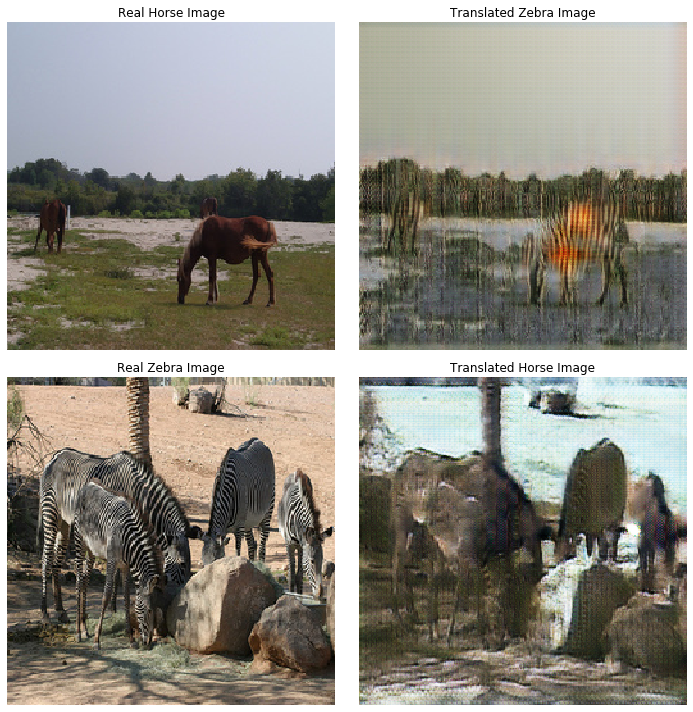

In [27]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(horse_img);
plt.title('Real Horse Image')
plt.axis('off');

plt.subplot(222)
fake_zebra_display = normalize_and_convert_color(fake_zebra[0])
plt.imshow(fake_zebra_display);
plt.title('Translated Zebra Image')
plt.axis('off');

plt.subplot(223)
plt.imshow(zebra_img)
plt.title('Real Zebra Image')
plt.axis('off');

plt.subplot(224)
fake_horse_display = normalize_and_convert_color(fake_horse[0])
plt.imshow(fake_horse_display);
plt.title('Translated Horse Image')
plt.axis('off');

plt.tight_layout()

Note the addition of zebra-like stripe texture on top of horses when translating from horses to zebras.
When translating zebras to horses, we can observe that generator removes the stripe texture from zebras.